<a href="https://colab.research.google.com/github/engineerJPark/Segmentation-to-World-Coordinate-by-FCN-and-Camera-Calibration/blob/master/FCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TODO

- take checker board calibration
- get distance and make extrinsic matrix

- validation IoU
- validation mAP

# model training and test

In [ ]:
import numpy as np
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from torchvision.models import resnet18, ResNet18_Weights

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset


# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 20.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'
from matplotlib import cm

import collections
import PIL
import os
import datetime


if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

torch.manual_seed(1)
if device == 'cuda:0':
    torch.cuda.manual_seed_all(1)

In [ ]:
print(torch.__version__)

1.12.1+cu113


In [ ]:
resnet_pretrained = resnet18(weights=ResNet18_Weights.DEFAULT)
# print(resnet_pretrained)

print('Turn Off the inplace operation')
print('.')
print('.')
print('.')

for name, child in resnet_pretrained.named_children():
    if isinstance(child, nn.ReLU):
        resnet_pretrained._modules[name] = nn.ReLU(inplace=False)
    elif isinstance(child, nn.Sequential):
        for sname, schild in child.named_children():
            for ssname, sschild in schild.named_children():
              if isinstance(sschild, nn.ReLU):
                  # print(name,sname,ssname)
                  resnet_pretrained._modules[name]._modules[sname]._modules[ssname] = nn.ReLU(inplace=False)

# print('--------------------------------')
# print('--------------------------------')
# print(resnet_pretrained)

print('Done.')

# torch.autograd.set_detect_anomaly(True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Turn Off the inplace operation
.
.
.
Done.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
ROOT_DIR = '/content/gdrive/MyDrive/voc_data'

Mounted at /content/gdrive


In [ ]:
class VOCClassSegBase(torch.utils.data.Dataset):

    class_names = np.array([
        'background',
        'aeroplane',
        'bicycle',
        'bird',
        'boat',
        'bottle',
        'bus',
        'car',
        'cat',
        'chair',
        'cow',
        'diningtable',
        'dog',
        'horse',
        'motorbike',
        'person',
        'potted plant',
        'sheep',
        'sofa',
        'train',
        'tv/monitor',
    ])

    def __init__(self, root='/content/gdrive/MyDrive/voc_data', split='train', transform_tf=True):
        self.root = root
        self.split = split
        self.transform_tf = transform_tf
        self.transform = transforms.Compose([
            transforms.Resize((320,320), interpolation=InterpolationMode.NEAREST),
            transforms.Normalize(mean=(0, 0, 0), std=(255., 255., 255.)),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        self.transform_lbl = transforms.Compose([
            transforms.Resize((320,320), interpolation=InterpolationMode.NEAREST)
        ])

        dataset_dir = os.path.join(self.root, 'VOCdevkit/VOC2012')
        self.files = collections.defaultdict(list)
        for split in ['train', 'val']:
            imgsets_file = os.path.join(
                dataset_dir, 'ImageSets/Segmentation/%s.txt' % split)
            for did in open(imgsets_file):
                did = did.strip()
                img_file = os.path.join(dataset_dir, 'JPEGImages/%s.jpg' % did)
                lbl_file = os.path.join(
                    dataset_dir, 'SegmentationClass/%s.png' % did)
                self.files[split].append({
                    'img': img_file,
                    'lbl': lbl_file,
                })

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        # data file
        data_file = self.files[self.split][index]
        
        # load
        img_file = data_file['img']
        img = PIL.Image.open(img_file)
        img = torch.from_numpy(np.array(img)).to(torch.float)

        lbl_file = data_file['lbl']
        lbl = PIL.Image.open(lbl_file)
        lbl = torch.from_numpy(np.array(lbl)).to(torch.long)
        lbl = torch.unsqueeze(lbl, dim=0)

        # image preprocessing
        img = img.permute(2, 0, 1) # HWC -> CHW
        lbl[lbl == 255] = -1

        # image transform
        if self.transform_tf == True:
            return self.transform(img), self.transform_lbl(lbl)
        else:
            return img, lbl


train_data = VOCClassSegBase(root=ROOT_DIR, split='train', transform_tf=True)

train_data_loader = DataLoader(dataset=train_data, batch_size = 1, drop_last=True)

In [ ]:
# Bilinear weights deconvolution Algorithm
def bilinear_kernel_init(Cin, Cout, kernel_size):
  factor = (kernel_size + 1) // 2
  if kernel_size % 2 == 1:
    center = factor - 1
  else:
    center = factor - 0.5

  og = (torch.arange(kernel_size).reshape(-1,1), torch.arange(kernel_size).reshape(1,-1))
  filter = (1 - torch.abs(og[0] - center) / factor) * (1 - torch.abs(og[1] - center) / factor)

  weight = torch.zeros((Cin, Cout, kernel_size, kernel_size))
  weight[range(Cin), range(Cout), :, :] = filter
  return weight.clone()

In [ ]:
class FCN18(nn.Module):
  def __init__(self, class_n): # class 20 + 1(bakcground)
    super().__init__()
    self.downsample1 = nn.Sequential( # 1/2 of the input
        resnet_pretrained.conv1,
        resnet_pretrained.bn1,
        resnet_pretrained.relu,
        resnet_pretrained.maxpool
    )
    self.downsample2 = resnet_pretrained.layer1 # 1/4 of the input
    self.downsample3 = resnet_pretrained.layer2 # 1/8 of the input, extract featuremap that through 1x1 conv
    self.downsample4 = resnet_pretrained.layer3 # 1/16 of the input, extract featuremap that through 1x1 conv
    self.downsample5 = resnet_pretrained.layer4 # 1/32 of the input, extract featuremap that through 1x1 conv

    self.fully_conv_pool3 = nn.Conv2d(128, class_n, kernel_size=1) # get class score for each pixel
    nn.init.xavier_normal_(self.fully_conv_pool3.weight)

    self.fully_conv_pool4 = nn.Conv2d(256, class_n, kernel_size=1) # get class score for each pixel
    nn.init.xavier_normal_(self.fully_conv_pool4.weight)

    self.fully_conv_pool5 = nn.Conv2d(512, class_n, kernel_size=1) # get class score for each pixel
    nn.init.xavier_normal_(self.fully_conv_pool5.weight)
    
    # stride s, padding s/2, kernelsize 2s -> 2 times upsampling for images
    self.upsample_make_16s = nn.ConvTranspose2d(class_n, class_n, kernel_size=4, padding=1, stride=2, bias=False) # to 1/16
    self.upsample_make_16s.weight.data.copy_(bilinear_kernel_init(class_n, class_n, 4))

    self.upsample_make_8s = nn.ConvTranspose2d(class_n, class_n, kernel_size=4, padding=1, stride=2, bias=False) # to 1/8
    self.upsample_make_8s.weight.data.copy_(bilinear_kernel_init(class_n, class_n, 4))
    
    self.upsample_to_score = nn.ConvTranspose2d(class_n, class_n, kernel_size=16, padding=4, stride=8) # to 1
    self.upsample_to_score.weight.data.copy_(bilinear_kernel_init(class_n, class_n, 16))
    for param in self.upsample_to_score.parameters(): # freeze the last layer
      param.requires_grad = False


  def forward(self, x):

    x = self.downsample1(x)
    x = self.downsample2(x)
    x = self.downsample3(x)
    pool3_score = self.fully_conv_pool3(x)
    x = self.downsample4(x)
    pool4_score = self.fully_conv_pool4(x)
    x = self.downsample5(x)
    pool5_score = self.fully_conv_pool5(x)

    pool4_2x_conv7 = pool4_score + self.upsample_make_16s(pool5_score)
    pool3_2x_pool4_4x_conv7 = pool3_score + self.upsample_make_8s(pool4_2x_conv7) # error log occured
    out = self.upsample_to_score(pool3_2x_pool4_4x_conv7)

    return out

In [ ]:
# epochs = 10
epochs = 13
lr = 10e-4
weight_decay = 2e-4
momentum = 0.9
batch_size = 64

model = FCN18(21)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss(ignore_index=-1)

In [ ]:
test_model = FCN18(21)
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
optimizer = optimizer

############################################################ fix this path
PATH = '/content/gdrive/MyDrive/fcn_model/model_8_14_8_19_46' # need to be fixed everytime

checkpoint = torch.load(PATH)
test_model.load_state_dict(checkpoint['model_state_dict']) 
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

test_model.train()
print('train mode start')

train mode start


In [ ]:
# train code
def train(model, epochs, optimizer, criterion):
  # with torch.autograd.detect_anomaly():
  for epoch in range(epochs):
    running_loss = 0
    for iter, (train_img, train_gt_img) in enumerate(train_data_loader):
      
      train_img = train_img.to(device)
      train_gt_img = train_gt_img.squeeze(dim=1).to(device)

      score_img = model(train_img)
      score_img = score_img.permute(0,2,3,1).reshape(-1, score_img.shape[1])
      train_gt_img = train_gt_img.reshape(-1, )

      loss = criterion(score_img, train_gt_img)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      print("epoch %d, iteration: %d, loss : %f "%(epoch + 1, iter + 1, loss))

      running_loss += loss
    
    print('======================================')
    print("epoch %d, loss : %f "%(epoch + 1, running_loss / len(train_data_loader)))

    now = datetime.datetime.now()
    EPOCH = epoch
    PATH = "/content/gdrive/MyDrive/fcn_model/model_%d_%d_%d_%d_%d" % (now.month, now.day, now.hour, now.minute, now.second)
    LOSS = running_loss

    torch.save({
                'epoch': EPOCH,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': LOSS,
                }, PATH)
  
  print("Training End")

train(model, epochs, optimizer, criterion)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
epoch 10, iteration: 866, loss : 0.055489 
epoch 10, iteration: 867, loss : 0.069883 
epoch 10, iteration: 868, loss : 0.194558 
epoch 10, iteration: 869, loss : 0.004105 
epoch 10, iteration: 870, loss : 0.020651 
epoch 10, iteration: 871, loss : 0.013086 
epoch 10, iteration: 872, loss : 0.026082 
epoch 10, iteration: 873, loss : 0.052662 
epoch 10, iteration: 874, loss : 0.038897 
epoch 10, iteration: 875, loss : 0.027507 
epoch 10, iteration: 876, loss : 0.015090 
epoch 10, iteration: 877, loss : 0.052751 
epoch 10, iteration: 878, loss : 0.024596 
epoch 10, iteration: 879, loss : 0.022488 
epoch 10, iteration: 880, loss : 0.012350 
epoch 10, iteration: 881, loss : 0.031657 
epoch 10, iteration: 882, loss : 0.023698 
epoch 10, iteration: 883, loss : 0.064322 
epoch 10, iteration: 884, loss : 0.005046 
epoch 10, iteration: 885, loss : 0.015884 
epoch 10, iteration: 886, loss : 0.060437 
epoch 10, iteration: 887, loss : 0.028207 
epoch 10, iteratio

## Test

In [ ]:
test_model = FCN18(21)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

############################################################ fix this path
PATH = '/content/gdrive/MyDrive/fcn_model/model_8_14_14_14_25' # need to be fixed

checkpoint = torch.load(PATH)
test_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

test_model.eval()
print('model evaluation start')

model evaluation start


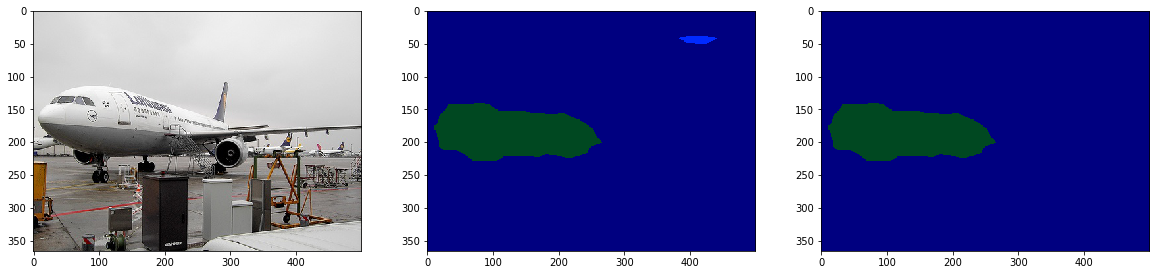

In [ ]:
# segmentation : plot image
with open(os.path.join(ROOT_DIR, "VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt"), 'r') as f:
  lines = f.readlines()
for i in range(len(lines)):
  lines[i] =  lines[i].strip('\n')
test_jpg = lines[0] + '.jpg'
test_image = PIL.Image.open(os.path.join(ROOT_DIR, 'VOCdevkit/VOC2012', "JPEGImages", test_jpg))

# test image showing
plt.figure(figsize=(20, 40))
plt.subplot(1,3,1)
plt.imshow(test_image)

# test image transform & input to test model
test_image = np.array(test_image)
test_image = torch.from_numpy(test_image).to(torch.float).permute(2,0,1)
ori_x, ori_y = test_image.shape[1], test_image.shape[2]

test_image = torch.unsqueeze(test_image, dim=0)

test_transform = transforms.Compose([
    transforms.Resize((320,320), interpolation=InterpolationMode.NEAREST),
    transforms.Normalize(mean=(0, 0, 0), std=(255., 255., 255.)),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])
return_transform = transforms.Compose([
    transforms.Resize((ori_x, ori_y), interpolation=InterpolationMode.NEAREST),
])

test_seg = test_model(
    test_transform(test_image)
    )
test_seg = return_transform(test_seg)
test_seg[test_seg <= 8] = 0 # Thresholding

# model prediction
test_image_channel_idx = torch.argmax(torch.squeeze(test_seg, dim=0), dim=0)

# print(test_image_channel_idx[30, 75])

# model prediction to PIL
test_image_PIL = PIL.Image.fromarray(
    np.uint8(cm.gist_ncar(test_image_channel_idx.detach().numpy()*10)*255)
    )

# predicted data showing
plt.subplot(1,3,2)
plt.imshow(test_image_PIL)

# model prediction for only one class
test_image_channel_idx_copy = copy.deepcopy(test_image_channel_idx)
finding_class = 1 # editable
test_image_channel_idx_copy[test_image_channel_idx_copy != finding_class] = 0

# to PIL
test_image_PIL = PIL.Image.fromarray(
    np.uint8(cm.gist_ncar(test_image_channel_idx_copy.detach().numpy()*10)*255)
    )

# predicted data showing
plt.subplot(1,3,3)
plt.imshow(test_image_PIL)
plt.show()

In [ ]:
# validation IoU mAP



In [ ]:
# validation mAP



# code for renaming

In [ ]:
# rename image and ground truth files

import os
from google.colab import drive

drive.mount('/content/gdrive')
ROOT_DIR = '/content/gdrive/MyDrive/Colab Notebooks/KAsimov PJT'

# 주어진 디렉토리에 있는 항목들의 이름을 담고 있는 리스트를 반환합니다.
# 리스트는 임의의 순서대로 나열됩니다.
file_path1 = os.path.join(ROOT_DIR, 'real_world_data/rgb')
file_names1 = os.listdir(file_path1)
file_names1.sort()
print(file_names1)

i = 1
for name in file_names1:
    src = os.path.join(file_path1, name)
    dst = 'rs_image_' + str(i) + '.jpg'
    dst = os.path.join(file_path1, dst)
    os.rename(src, dst)
    i += 1

file_path2 = os.path.join(ROOT_DIR, 'real_world_data/gt')
file_names2 = os.listdir(file_path2)
file_names2.sort()
print(file_names2)

i = 1
for name in file_names2:
    src = os.path.join(file_path2, name)
    dst = 'rs_gt_' + str(i) + '.png'
    dst = os.path.join(file_path2, dst)
    os.rename(src, dst)
    i += 1

Mounted at /content/gdrive
['rs_image_100_jpg.rf.4613b5e60ee784e8f8e991485621047c.jpg', 'rs_image_100_jpg.rf.531a9ce5062ae15259e53dd0d48f3394.jpg', 'rs_image_100_jpg.rf.cea985d5dfedbd91597d3e23dc7b788e.jpg', 'rs_image_101_jpg.rf.70ed12f31320a8be654fe54e308343a7.jpg', 'rs_image_101_jpg.rf.d264abcfb89938baf36bbc5278bb7828.jpg', 'rs_image_101_jpg.rf.d4c2b8587a1d123d7538d2cf0009aa4e.jpg', 'rs_image_102_jpg.rf.0f63941e7f0bf339e361b4a4cd8c8463.jpg', 'rs_image_102_jpg.rf.3c1632d824ad91c3aed95c34efea5875.jpg', 'rs_image_102_jpg.rf.7ede7c3a247f81b765a575a7c7ccde6c.jpg', 'rs_image_103_jpg.rf.4bd3a2cdc3dd8ed97f77c1678a739072.jpg', 'rs_image_103_jpg.rf.5ab4fcbcf2732ced631fc53616031637.jpg', 'rs_image_103_jpg.rf.64495450141856387f80b4094eb89ddc.jpg', 'rs_image_104_jpg.rf.4b06720b89b2f40f7b57adece44fabec.jpg', 'rs_image_104_jpg.rf.4c5467116523f95f99cb7cf53e0fda41.jpg', 'rs_image_104_jpg.rf.c06df222d400e7542935bdeb1360ac32.jpg', 'rs_image_105_jpg.rf.10c849f0fa70f26d4e0ca2d50df63e7c.jpg', 'rs_image_10

# code for re-training

In [69]:
import numpy as np
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from torchvision.models import resnet18, ResNet18_Weights

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset


# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 20.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'
from matplotlib import cm

import collections
import PIL
import os
import datetime


if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

torch.manual_seed(1)
if device == 'cuda:0':
    torch.cuda.manual_seed_all(1)

print(torch.__version__)

! pip install torchmetrics
import torchmetrics as tm

1.12.1+cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [70]:
import os
from google.colab import drive

drive.mount('/content/gdrive')
ROOT_DIR = '/content/gdrive/MyDrive/Colab Notebooks/KAsimov PJT'

# dataset for new image

class VOCClassSegBase(torch.utils.data.Dataset):
  '''
  input size : (480, 640, 3) (480, 640)
  '''

  class_names = np.array([
      'background',
      'roll',
      'sauce',
      'snack',
  ])

  def __init__(self, root='/content/gdrive/MyDrive/Colab Notebooks/KAsimov PJT', split='train', transform_tf=True):
      self.root = root
      self.split = split
      self.transform_tf = transform_tf
      self.transform = transforms.Compose([ # interpolation=InterpolationMode.BILINEAR
          transforms.Normalize(mean=(0, 0, 0), std=(255., 255., 255.)),
          transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
      ])

      file_names_rgb = os.listdir(os.path.join(ROOT_DIR, 'real_world_data/rgb'))
      file_names_rgb.sort()

      DATASET_DIR = os.path.join(self.root, 'real_world_data')
      self.files = collections.defaultdict(list)
      for split in ['train', 'val']:
        for i in range(len(file_names_rgb)):
            img_file = os.path.join(DATASET_DIR, 'rgb/rs_image_%d.jpg' % (i + 1))
            lbl_file = os.path.join(DATASET_DIR, 'gt/rs_gt_%d.png' % (i + 1))
            self.files[split].append({
                'img': img_file,
                'lbl': lbl_file,
            })

  def __len__(self):
      return len(self.files[self.split])

  def __getitem__(self, index):
      # data file
      data_file = self.files[self.split][index]
      
      # load
      img_file = data_file['img']
      img = PIL.Image.open(img_file)
      img = torch.from_numpy(np.array(img)).to(torch.float)

      lbl_file = data_file['lbl']
      lbl = PIL.Image.open(lbl_file)
      lbl = torch.from_numpy(np.array(lbl)).to(torch.long)
      lbl = torch.unsqueeze(lbl, dim=0)

      # 반드시 확인해야할 것
      # image preprocessing
      img = img.permute(2, 0, 1) # HWC -> CHW 
      lbl[lbl == 255] = -1

      # image transform
      if self.transform_tf == True:
          return self.transform(img), lbl
      else:
          return img, lbl

train_data = VOCClassSegBase(root=ROOT_DIR, split='train', transform_tf=True)
train_data_loader = DataLoader(dataset=train_data, batch_size = 1, drop_last=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [71]:
# resnet pretrained download
resnet_pretrained = resnet18(weights=ResNet18_Weights.DEFAULT)
# print(resnet_pretrained)

print('Turn Off the inplace operation')
print('.')
print('.')
print('.')

for name, child in resnet_pretrained.named_children():
    if isinstance(child, nn.ReLU):
        resnet_pretrained._modules[name] = nn.ReLU(inplace=False)
    elif isinstance(child, nn.Sequential):
        for sname, schild in child.named_children():
            for ssname, sschild in schild.named_children():
              if isinstance(sschild, nn.ReLU):
                  # print(name,sname,ssname)
                  resnet_pretrained._modules[name]._modules[sname]._modules[ssname] = nn.ReLU(inplace=False)

print('Done.')

# Bilinear weights deconvolution Algorithm
def bilinear_kernel_init(Cin, Cout, kernel_size):
  factor = (kernel_size + 1) // 2
  if kernel_size % 2 == 1:
    center = factor - 1
  else:
    center = factor - 0.5

  og = (torch.arange(kernel_size).reshape(-1,1), torch.arange(kernel_size).reshape(1,-1))
  filter = (1 - torch.abs(og[0] - center) / factor) * (1 - torch.abs(og[1] - center) / factor)

  weight = torch.zeros((Cin, Cout, kernel_size, kernel_size))
  weight[range(Cin), range(Cout), :, :] = filter
  return weight.clone()

# FCN18 declaration
class FCN18(nn.Module):
  def __init__(self, class_n): # class 20 + 1(bakcground)
    super().__init__()
    self.downsample1 = nn.Sequential( # 1/2 of the input
        resnet_pretrained.conv1,
        resnet_pretrained.bn1,
        resnet_pretrained.relu,
        resnet_pretrained.maxpool
    )
    self.downsample2 = resnet_pretrained.layer1 # 1/4 of the input
    self.downsample3 = resnet_pretrained.layer2 # 1/8 of the input, extract featuremap that through 1x1 conv
    self.downsample4 = resnet_pretrained.layer3 # 1/16 of the input, extract featuremap that through 1x1 conv
    self.downsample5 = resnet_pretrained.layer4 # 1/32 of the input, extract featuremap that through 1x1 conv

    self.fully_conv_pool3 = nn.Conv2d(128, class_n, kernel_size=1) # get class score for each pixel
    nn.init.xavier_normal_(self.fully_conv_pool3.weight)

    self.fully_conv_pool4 = nn.Conv2d(256, class_n, kernel_size=1) # get class score for each pixel
    nn.init.xavier_normal_(self.fully_conv_pool4.weight)

    self.fully_conv_pool5 = nn.Conv2d(512, class_n, kernel_size=1) # get class score for each pixel
    nn.init.xavier_normal_(self.fully_conv_pool5.weight)
    
    # stride s, padding s/2, kernelsize 2s -> 2 times upsampling for images
    self.upsample_make_16s = nn.ConvTranspose2d(class_n, class_n, kernel_size=4, padding=1, stride=2, bias=False) # to 1/16
    self.upsample_make_16s.weight.data.copy_(bilinear_kernel_init(class_n, class_n, 4))

    self.upsample_make_8s = nn.ConvTranspose2d(class_n, class_n, kernel_size=4, padding=1, stride=2, bias=False) # to 1/8
    self.upsample_make_8s.weight.data.copy_(bilinear_kernel_init(class_n, class_n, 4))
    
    self.upsample_to_score = nn.ConvTranspose2d(class_n, class_n, kernel_size=16, padding=4, stride=8) # to 1
    self.upsample_to_score.weight.data.copy_(bilinear_kernel_init(class_n, class_n, 16))
    for param in self.upsample_to_score.parameters(): # freeze the last layer
      param.requires_grad = False


  def forward(self, x):

    x = self.downsample1(x)
    x = self.downsample2(x)
    x = self.downsample3(x)
    pool3_score = self.fully_conv_pool3(x)
    x = self.downsample4(x)
    pool4_score = self.fully_conv_pool4(x)
    x = self.downsample5(x)
    pool5_score = self.fully_conv_pool5(x)

    pool4_2x_conv7 = pool4_score + self.upsample_make_16s(pool5_score)
    pool3_2x_pool4_4x_conv7 = pool3_score + self.upsample_make_8s(pool4_2x_conv7)
    out = self.upsample_to_score(pool3_2x_pool4_4x_conv7)

    return out

Turn Off the inplace operation
.
.
.
Done.


In [72]:
# import copy

# epochs = 30
# lr = 10e-4
# weight_decay = 1e-8
# momentum = 0.9

# # data loading from the file
# model = FCN18(4)
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
# criterion = nn.CrossEntropyLoss(ignore_index=-1)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# ############################################################ fix this path. need to be fixed everytime
# PATH = '/content/gdrive/MyDrive/Colab Notebooks/KAsimov PJT/fcn_model/21class_trained/model_8_14_14_14_25_21class'

# checkpoint = torch.load(PATH)
# state_dict = checkpoint['model_state_dict']
# new_state_dict = collections.OrderedDict()

# with torch.no_grad():
#   for key in state_dict:
#     if key.split('.')[0][:-1] == 'downsample':
#       new_state_dict[key] = copy.deepcopy(state_dict[key])

# model.load_state_dict(new_state_dict,strict=False) 

# model.train()
# print('train mode start')

# model.downsample1.requires_grad = False
# model.downsample2.requires_grad = False
# model.downsample3.requires_grad = False
# model.downsample4.requires_grad = False
# model.downsample5.requires_grad = False

In [73]:
# # 이어서 학습할 때 사용
# epochs = 6
# lr = 10e-5
# weight_decay = 1e-8
# momentum = 0.9

# # data loading from the file
# model = FCN18(4)
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
# criterion = nn.CrossEntropyLoss(ignore_index=-1)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# ############################################################ fix this path
# PATH = '/content/gdrive/MyDrive/Colab Notebooks/KAsimov PJT/fcn_model/model_8_17_0_18_43'

# checkpoint = torch.load(PATH)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

# model.train()
# print('train mode start')

In [74]:
# # train code
# def train(model, epochs, optimizer, criterion):
#   # with torch.autograd.detect_anomaly():
#   for epoch in range(epochs):
#     running_loss = 0
#     for iter, (train_img, train_gt_img) in enumerate(train_data_loader):
      
#       train_img = train_img.to(device)
#       train_gt_img = train_gt_img.squeeze(dim=1).to(device)

#       score_img = model(train_img)
#       score_img = score_img.permute(0,2,3,1).reshape(-1, score_img.shape[1])
#       train_gt_img = train_gt_img.reshape(-1, )

#       loss = criterion(score_img, train_gt_img)

#       optimizer.zero_grad()
#       loss.backward()
#       optimizer.step()

#       print("epoch %d, iteration: %d, loss : %f "%(epoch + 1, iter + 1, loss))

#       running_loss += loss
    
#     print('======================================')
#     print("epoch %d, loss : %f "%(epoch + 1, running_loss / len(train_data_loader)))

#     now = datetime.datetime.now()
#     EPOCH = epoch
#     PATH = "/content/gdrive/MyDrive/Colab Notebooks/KAsimov PJT/fcn_model/model_%d_%d_%d_%d_%d" % (now.month, now.day, now.hour, now.minute, now.second)
#     LOSS = running_loss / len(train_data_loader)

#     torch.save({
#                 'epoch': EPOCH,
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'loss': LOSS,
#                 }, PATH)
#     scheduler.step()
  
#   print("Training End")
#   return (now.month, now.day, now.hour, now.minute, now.second)

# month, day, hour, minute, second = train(model, epochs, optimizer, criterion)

## Test

In [75]:
test_model = FCN18(4)

############################################################ fix this path
# PATH = '/content/gdrive/MyDrive/Colab Notebooks/KAsimov PJT/fcn_model/model_%d_%d_%d_%d_%d' % (month, day, hour, minute, second)
PATH = '/content/gdrive/MyDrive/Colab Notebooks/KAsimov PJT/fcn_model/4class_trained/model_8_17_7_31_29'
print(PATH) # /content/gdrive/MyDrive/Colab Notebooks/KAsimov PJT/fcn_model/4class_trained/model_8_17_7_31_29

checkpoint = torch.load(PATH)
test_model.load_state_dict(checkpoint['model_state_dict'])

test_model.eval()
print('model evaluation start')

/content/gdrive/MyDrive/Colab Notebooks/KAsimov PJT/fcn_model/4class_trained/model_8_17_7_31_29
model evaluation start


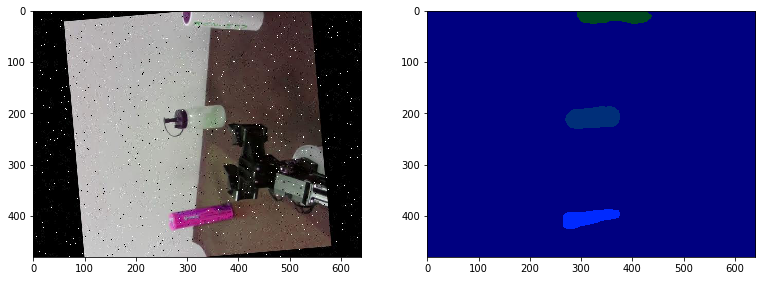

In [76]:
# segmentation : plot image
img_num = 1
test_image = PIL.Image.open('/content/gdrive/MyDrive/Colab Notebooks/KAsimov PJT/real_world_data/rgb/rs_image_%d.jpg' % (img_num))

# test image showing
plt.figure(figsize=(20, 40))
plt.subplot(1,3,1)
plt.imshow(test_image)

# test image transform & input to test model
test_image = np.array(test_image)
test_image = torch.from_numpy(test_image).to(torch.float).permute(2,0,1)

test_image = torch.unsqueeze(test_image, dim=0)

test_transform = transforms.Compose([ # interpolation=InterpolationMode.BILINEAR
    transforms.Normalize(mean=(0, 0, 0), std=(255., 255., 255.)),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

test_seg = test_model(test_transform(test_image))
test_seg = torch.squeeze(test_seg, dim=0)
# model prediction
test_image_channel_idx = torch.argmax(test_seg, dim=0)

# print(test_image_channel_idx[30, 75])

# model prediction to PIL
test_image_PIL = PIL.Image.fromarray(
    np.uint8(cm.gist_ncar(test_image_channel_idx.detach().numpy()*10)*255)
    )

# predicted data showing
plt.subplot(1,3,2)
plt.imshow(test_image_PIL)
plt.show()


In [77]:
# IoU

# 이거 전체 데이터에 대해서 반복하면 mean IoU 나온다.

test_gt_image = PIL.Image.open('/content/gdrive/MyDrive/Colab Notebooks/KAsimov PJT/real_world_data/gt/rs_gt_%d.png' % (img_num))
test_gt_image = np.array(test_gt_image)
test_gt_image = torch.from_numpy(test_gt_image).to(torch.int)

iou = tm.JaccardIndex(num_classes=4)
print(iou(test_image_channel_idx, test_gt_image))

tensor(0.7816)


In [86]:
# mAP is not calculated because it is segmentation
# 이거 전체 데이터에 대해서 반복하면 mAP 나온다.

import torchmetrics.detection.mean_ap as tm_map

preds = []

scores=test_seg[1].clone()
scores[test_image_channel_idx != 1] = 0
labels=test_image_channel_idx
masks=(test_image_channel_idx == 1)
# masks=torch.unsqueeze(masks, dim=0)

preds.append(dict(scores=scores, labels=labels, masks=masks))

scores=test_seg[2].clone()
scores[test_image_channel_idx != 2] = 0
labels=test_image_channel_idx
masks=(test_image_channel_idx == 2)
# masks=torch.unsqueeze(masks, dim=0)

preds.append(dict(scores=scores, labels=labels, masks=masks))

scores=test_seg[3].clone()
scores[test_image_channel_idx != 3] = 0
labels=test_image_channel_idx
masks=(test_image_channel_idx == 3)
# masks=torch.unsqueeze(masks, dim=0)

preds.append(dict(scores=scores, labels=labels, masks=masks))

# preds = [
#   dict(
#     scores=test_seg[1].clone(),
#     scores[test_image_channel_idx != 1] = 0,
#     # scores=test_seg[1],
#     labels=test_image_channel_idx,
#     masks=(test_image_channel_idx == 1)
#   ),
#     dict(
#     scores=test_seg[2].clone(),
#     scores[test_image_channel_idx != 2] = 0,
#     # scores=test_seg[2],
#     labels=test_image_channel_idx,
#     masks=(test_image_channel_idx == 2)
#   ),
#     dict(
#     scores=test_seg[3].clone(),
#     scores[test_image_channel_idx != 3] = 0,
#     # scores=test_seg[3],
#     labels=test_image_channel_idx,
#     masks=(test_image_channel_idx == 3)
#   )
    
  # dict(
  #   scores=test_seg[1][test_image_channel_idx == 1],
  #   labels=torch.ones((test_image_channel_idx[test_image_channel_idx == 1].reshape(-1, ).shape[0], )) * 1,
  #   masks=test_image_channel_idx[test_image_channel_idx == 1]
  # ),
  #   dict(
  #   scores=test_seg[2][test_image_channel_idx == 2],
  #   labels=torch.ones((test_image_channel_idx[test_image_channel_idx == 2].reshape(-1, ).shape[0], )) * 2,
  #   masks=test_image_channel_idx[test_image_channel_idx == 2]
  # ),
  #   dict(
  #   scores=test_seg[3][test_image_channel_idx == 3],
  #   labels=torch.ones((test_image_channel_idx[test_image_channel_idx == 3].reshape(-1, ).shape[0], )) * 3,
  #   masks=test_image_channel_idx[test_image_channel_idx == 3]
  # )
# ]

# print(preds[0]['scores'].shape)
# print(preds[0]['labels'].shape)
# print(preds[0]['masks'].shape)

targets = []

labels=test_gt_image
masks=(test_gt_image == 1)
# masks=torch.unsqueeze(masks, dim=0)

targets.append(dict(labels=labels, masks=masks))

labels=test_gt_image
masks=(test_gt_image == 2)
# masks=torch.unsqueeze(masks, dim=0)

targets.append(dict(labels=labels, masks=masks))

labels=test_gt_image
masks=(test_gt_image == 3)
# masks=torch.unsqueeze(masks, dim=0)

targets.append(dict(labels=labels, masks=masks))

# targets = [
#   dict(
#     labels=test_gt_image,
#     masks=(test_gt_image == 1)
#   ),
#     dict(
#     labels=test_gt_image,
#     masks=(test_gt_image == 2)
#   ),
#     dict(
#     labels=test_gt_image,
#     masks=(test_gt_image == 3)
#   )
    
  # dict(
  #   labels=torch.ones((test_gt_image[test_gt_image == 1].reshape(-1, ).shape[0], )) * 1,
  #   masks=test_gt_image[test_gt_image == 1]
  # ),
  #   dict(
  #   labels=torch.ones((test_gt_image[test_gt_image == 2].reshape(-1, ).shape[0], )) * 2,
  #   masks=test_gt_image[test_gt_image == 2]
  # ),
  #   dict(
  #   labels=torch.ones((test_gt_image[test_gt_image == 3].reshape(-1, ).shape[0], )) * 3,
  #   masks=test_gt_image[test_gt_image == 3]
  # )
# ]

mAP = tm_map.MeanAveragePrecision(iou_type='segm')
mAP.update(preds, targets)
from pprint import pprint
pprint(mAP.compute())

TypeError: ignored

# Reference

# mAP and IoU implementation

- https://torchmetrics.readthedocs.io/en/stable/detection/mean_average_precision.html
- https://github.com/Cartucho/mAP
- https://stackoverflow.com/questions/48260415/pytorch-how-to-compute-iou-jaccard-index-for-semantic-segmentation

- https://torchmetrics.readthedocs.io/en/stable/detection/mean_average_precision.html
- https://torchmetrics.readthedocs.io/en/latest/classification/jaccard_index.html?highlight=IoU
- mAP 구현
  - https://www.youtube.com/watch?v=FppOzcDvaDI&ab_channel=AladdinPersson
  - https://github.com/ternaus/iglovikov_helper_functions/blob/master/iglovikov_helper_functions/metrics/map.py